# qMC integration on a $d$-simplex

The `Sort` and `Root` transformations $\mathbf{x}\rightarrow\mathbf{u}$, $\mathbf{x}\in[0,1]^d, \mathbf{u}\in T_d$ studied here are defined in

    Tim Pillards, Ronald Cools
    "Transforming low-discrepancy sequences from a cube to a simplex"
    Journal of Computational and Applied Mathematics
    Volume 174, Issue 1, 2005, Pages 29-42
    
https://doi.org/10.1016/j.cam.2004.03.019

There are a few more transformations described in that paper, which do not fit our needs.

- `Drop` discards sequence points, retains only $N / d!$ out of $N$ points.
- `Mirror` is discontinuous.
- `Origami` becomes exponentially hard for large $d$.
- `Shift` is not defined for $d > 2$.

In [2]:
import PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

In [3]:
import Sobol: SobolSeq, next!, skip

"""
    Volume of a d-dimensional simplex.
"""
simplex_vol(d::Int) = 1 / factorial(d);

"""
    Quasi Monte Carlo integration on a d-dimensional simplex.

    `f`        Integrand.
    `d`        Dimension of the problem.
    `trans`    Transformation from a d-dimensional unit cube to the simplex.
    `jacobian` Jacobian of the transformation.
    `seq`      Sobol low-discrepancy-sequence.
    `N`        Number of samples.
"""
function qMCIntegrateInSimplex(f, d::Int, trans, seq::SobolSeq, N::Int)
    s = 0
    for i = 1:N
        s += f(trans(next!(seq)))
    end
    s * (simplex_vol(d) / N)
end;

## `Sort` transformation of a $d$-dimensional unit cube

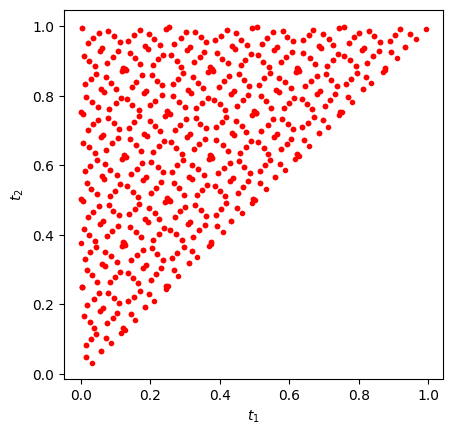

In [7]:
seq = SobolSeq(2)

p = reduce(hcat, sort(next!(seq)) for i = 1:1024)'
plt.subplot(111, aspect = "equal")
plt.plot(p[:,1], p[:,2], "r.")
plt.xlabel(raw"$u_1$");
plt.ylabel(raw"$u_2$");

## `Root` transformation of a $d$-dimensional unit cube

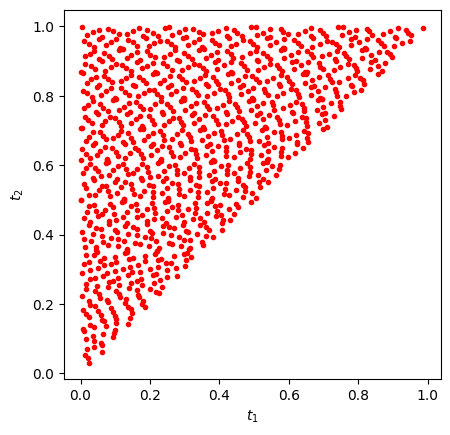

In [8]:
"""
    Make a Root transformation from a d-dimensional unit cube to the simplex.
"""
function make_trans_root(d::Int)
    x -> begin
        u = Vector{Float64}(undef, d)
        u[d] = x[d] ^ (1.0/d)
        for s = d-1:-1:1
            u[s] = u[s + 1] * (x[s] ^ (1.0 / s))
        end
        return u
    end
end;

seq = SobolSeq(2)
trans = make_trans_root(2)

p = reduce(hcat, trans(next!(seq)) for i = 1:1024)'
plt.subplot(111, aspect = "equal")
plt.plot(p[:,1], p[:,2], "r.")
plt.xlabel(raw"$u_1$");
plt.ylabel(raw"$u_2$");

## Scan a range of sample numbers $N$

In [9]:
function scan_N_range(f, d::Int, trans, N_step::Int, N_chunks::Int; verbose = false)
    N_list = zeros(Int, N_chunks)
    chunks = zeros(Float64, N_chunks)
    
    seq = SobolSeq(d)
    seq = skip(seq, N_step * N_chunks) # Acclaimed better uniformity see Sobol.jl docs
    for i = 1:N_chunks
        N = i * N_step
        N_list[i] = N
        
        chunks[i] = qMCIntegrateInSimplex(f, d, trans, seq, N)
        
        if verbose
            println("Chunk $i: N ∈ [$N; $(N + N_step)[: contribution = $(chunks[i])")
            flush(stdout)
        end
    end
    results = cumsum(chunks)
    for i = 1:N_chunks
        results[i] /= i
    end
    (N_list, results)
end

function plot_N_convergence(N_list, div_list, label_list, pdf_filename)
    fig, axes = plt.subplots(1, 2)
    fig.tight_layout()
    
    y_min, y_max = Inf, -Inf
    for (div, label) in Iterators.zip(div_list, label_list)
        y = abs.(div)
        axes[1].loglog(N_list, y, label = label)
        y_min = min(y_min, minimum(y))
        y_max = max(y_max, maximum(y))
        for i = -3:5
            axes[1].loglog(N_list, 10. .^i ./N_list, "-k", lw=0.5)
            axes[1].loglog(N_list, 10. .^(i-2) ./ sqrt.(N_list), ":k", lw=0.5)
        end
    end

    axes[1].set_xlabel(raw"$N$")
    axes[1].set_ylabel(raw"$|I - I_{ref}|$")
    axes[1].set_xlim(N_list[1], N_list[end])
    axes[1].set_ylim(y_min, y_max)
    axes[1].legend()
    
    y_min, y_max = Inf, -Inf
    for (div, label) in Iterators.zip(div_list, label_list)
        y = abs.(div) .* N_list
        axes[2].semilogx(N_list, y, label = label)
        y_min = min(y_min, minimum(y))
        y_max = max(y_max, maximum(y))
    end
        
    axes[2].set_xlabel(raw"$N$")
    axes[2].set_ylabel(raw"$N|I - I_{ref}|$")
    axes[2].set_xlim(N_list[1], N_list[end])
    axes[2].set_ylim(y_min, y_max)
    axes[2].legend()
    
    plt.savefig(pdf_filename)
end

plot_N_convergence (generic function with 1 method)

## $d = 1$

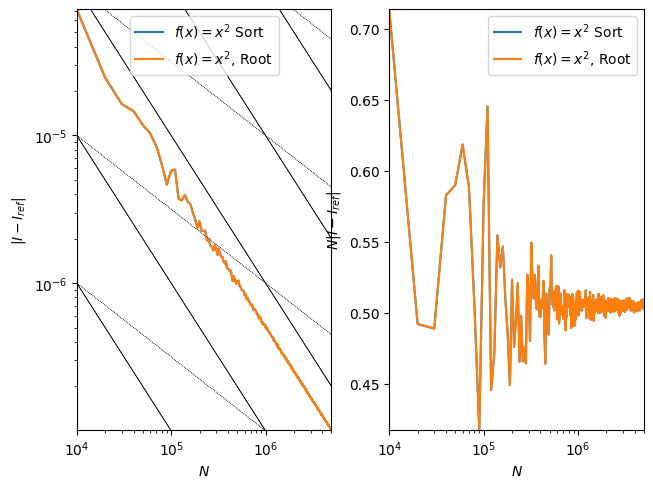

193.086368 seconds (3.76 G allocations: 223.966 GiB, 9.98% gc time, 0.02% compilation time)
194.599074 seconds (3.76 G allocations: 223.966 GiB, 10.68% gc time, 0.01% compilation time)


In [64]:
d = 1
seq = SobolSeq(d)

N_step = 10000
N_chunks = 500

f = x -> sum(x.^2)
ref = 1/3

@time N_list, results_sort = scan_N_range(f, d, sort, N_step, N_chunks)
@time N_list, results_root = scan_N_range(f, d, make_trans_root(d), N_step, N_chunks)

plot_N_convergence(N_list,
                   [results_sort .- ref, results_root .- ref],
                   [raw"$f(x) = x^2$ Sort", raw"$f(x) = x^2$, Root"],
                   "qMC_x2_1d.pdf")

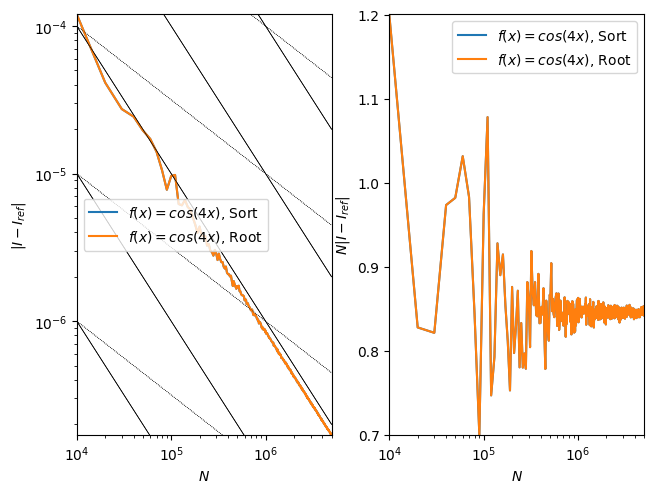

277.398398 seconds (5.01 G allocations: 298.621 GiB, 9.34% gc time, 0.01% compilation time)
284.069334 seconds (5.01 G allocations: 298.621 GiB, 9.32% gc time, 0.00% compilation time)


In [65]:
d = 1
seq = SobolSeq(d)

N_step = 10000
N_chunks = 500

f = x -> sum(cos.(4x))
ref = sin(4) / 4

@time N_list, results_sort = scan_N_range(f, d, sort, N_step, N_chunks)
@time N_list, results_root = scan_N_range(f, d, make_trans_root(d), N_step, N_chunks)

plot_N_convergence(N_list,
                   [results_sort .- ref, results_root .- ref],
                   [raw"$f(x) = cos(4x)$, Sort", raw"$f(x) = cos(4x)$, Root"],
                   "qMC_cos4x_1d.pdf")

## $d = 2$

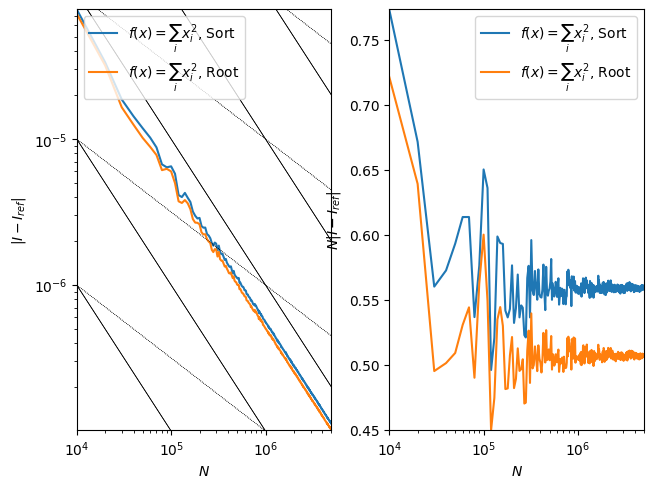

In [68]:
d = 2
seq = SobolSeq(d)

N_step = 10000
N_chunks = 500

f = x -> sum(x.^2)
ref = 1/3

@time N_list, results_sort = scan_N_range(f, d, sort, N_step, N_chunks)
@time N_list, results_root = scan_N_range(f, d, make_trans_root(d), N_step, N_chunks)

plot_N_convergence(N_list,
                   [results_sort .- ref, results_root .- ref],
                   [raw"$f(x) = \sum_i x_i^2$, Sort", raw"$f(x) = \sum_i x_i^2$, Root"],
                   "qMC_x2_2d.pdf")

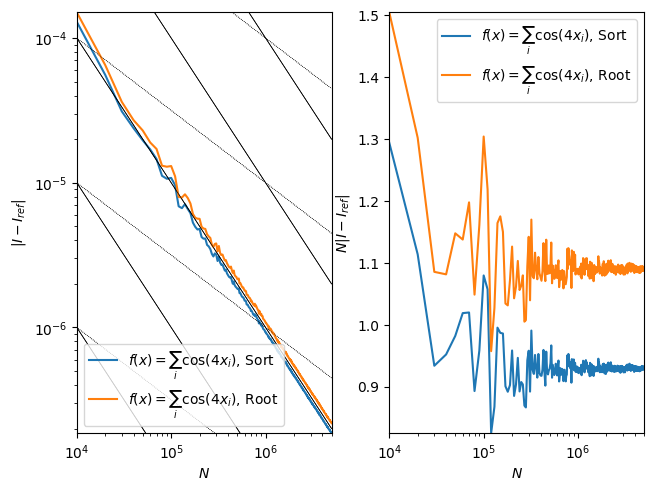

338.527369 seconds (5.01 G allocations: 373.276 GiB, 8.46% gc time, 0.01% compilation time)
334.771477 seconds (5.01 G allocations: 373.275 GiB, 8.73% gc time, 0.00% compilation time)


In [69]:
d = 2
seq = SobolSeq(d)

N_step = 10000
N_chunks = 500

f = x -> sum(cos.(4x))
ref = sin(4) / 4

@time N_list, results_sort = scan_N_range(f, d, sort, N_step, N_chunks)
@time N_list, results_root = scan_N_range(f, d, make_trans_root(d), N_step, N_chunks)

plot_N_convergence(N_list,
                   [results_sort .- ref, results_root .- ref],
                   [raw"$f(x) = \sum_i \cos(4x_i)$, Sort", raw"$f(x) = \sum_i \cos(4x_i)$, Root"],
                   "qMC_cos4x_2d.pdf")

## $d = 3$

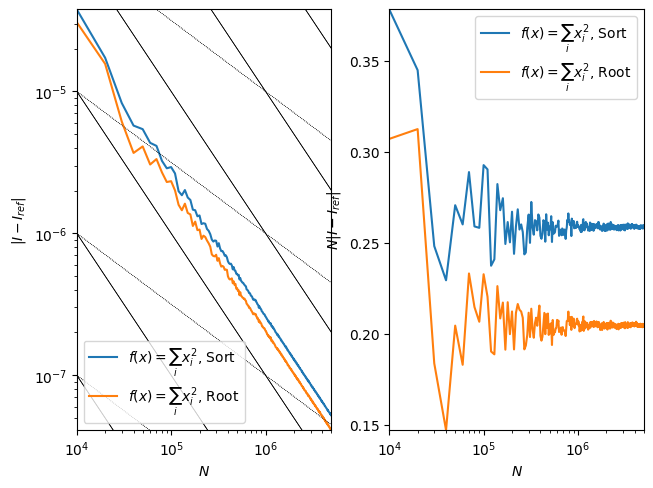

240.296694 seconds (3.76 G allocations: 279.986 GiB, 7.71% gc time, 0.09% compilation time)
375.553436 seconds (3.76 G allocations: 279.957 GiB, 5.47% gc time, 0.00% compilation time)


In [10]:
d = 3
seq = SobolSeq(d)

N_step = 10000
N_chunks = 500

f = x -> sum(x.^2)
ref = 1/6

@time N_list, results_sort = scan_N_range(f, d, sort, N_step, N_chunks)
@time N_list, results_root = scan_N_range(f, d, make_trans_root(d), N_step, N_chunks)

plot_N_convergence(N_list,
                   [results_sort .- ref, results_root .- ref],
                   [raw"$f(x) = \sum_i x_i^2$, Sort", raw"$f(x) = \sum_i x_i^2$, Root"],
                   "qMC_x2_3d.pdf")

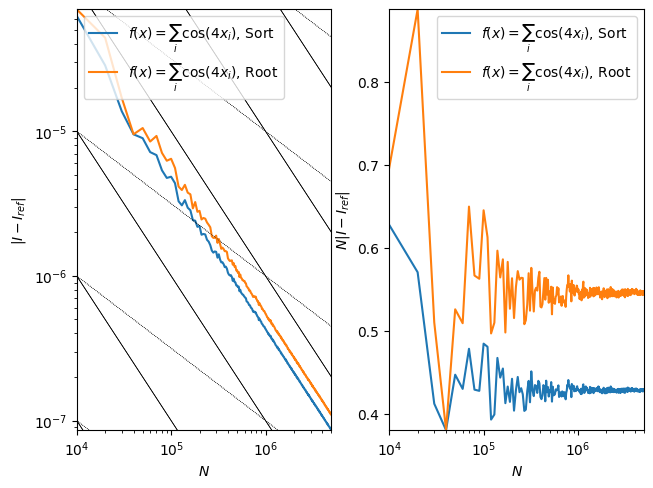

421.545406 seconds (5.01 G allocations: 373.292 GiB, 7.11% gc time, 0.03% compilation time)
523.428949 seconds (5.01 G allocations: 373.275 GiB, 5.48% gc time, 0.00% compilation time)


In [11]:
d = 3
seq = SobolSeq(d)

N_step = 10000
N_chunks = 500

f = x -> sum(cos.(4x))
ref = sin(4) / 8

@time N_list, results_sort = scan_N_range(f, d, sort, N_step, N_chunks)
@time N_list, results_root = scan_N_range(f, d, make_trans_root(d), N_step, N_chunks)

plot_N_convergence(N_list,
                   [results_sort .- ref, results_root .- ref],
                   [raw"$f(x) = \sum_i \cos(4x_i)$, Sort", raw"$f(x) = \sum_i \cos(4x_i)$, Root"],
                   "qMC_cos4x_3d.pdf")

## $d = 4$

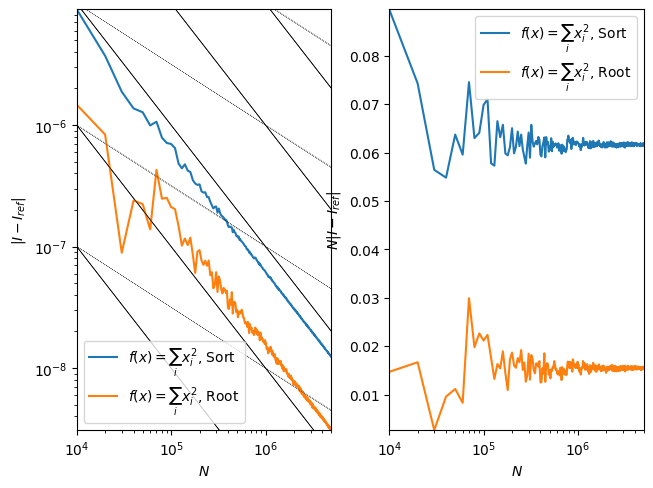

261.312450 seconds (3.76 G allocations: 335.953 GiB, 2.90% gc time, 0.03% compilation time)
449.224550 seconds (3.76 G allocations: 335.948 GiB, 1.76% gc time, 0.00% compilation time)


In [12]:
d = 4
seq = SobolSeq(d)

N_step = 10000
N_chunks = 500

f = x -> sum(x.^2)
ref = 1/18

@time N_list, results_sort = scan_N_range(f, d, sort, N_step, N_chunks)
@time N_list, results_root = scan_N_range(f, d, make_trans_root(d), N_step, N_chunks)

plot_N_convergence(N_list,
                   [results_sort .- ref, results_root .- ref],
                   [raw"$f(x) = \sum_i x_i^2$, Sort", raw"$f(x) = \sum_i x_i^2$, Root"],
                   "qMC_x2_4d.pdf")

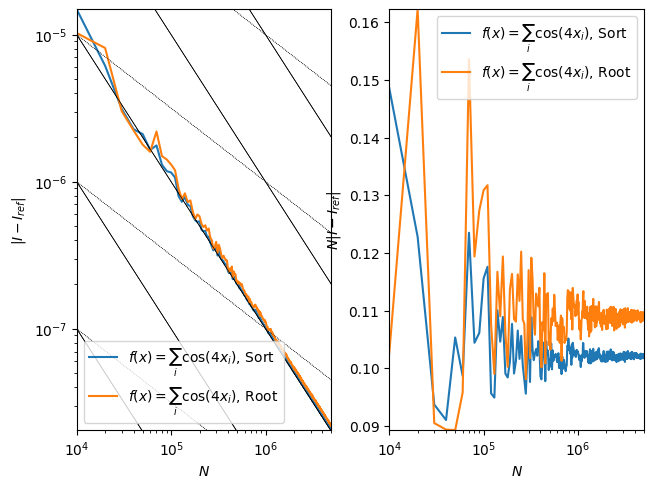

384.149797 seconds (5.01 G allocations: 447.931 GiB, 2.68% gc time, 0.01% compilation time)
681.150958 seconds (5.01 G allocations: 447.930 GiB, 1.81% gc time, 0.00% compilation time)


In [13]:
d = 4
seq = SobolSeq(d)

N_step = 10000
N_chunks = 500

f = x -> sum(cos.(4x))
ref = sin(4) / 24

@time N_list, results_sort = scan_N_range(f, d, sort, N_step, N_chunks)
@time N_list, results_root = scan_N_range(f, d, make_trans_root(d), N_step, N_chunks)

plot_N_convergence(N_list,
                   [results_sort .- ref, results_root .- ref],
                   [raw"$f(x) = \sum_i \cos(4x_i)$, Sort", raw"$f(x) = \sum_i \cos(4x_i)$, Root"],
                   "qMC_cos4x_4d.pdf")